In [444]:
import ticktack # For the compilation of the model
import ode      # As a method of solving the odes

from jax import jacfwd, jacrev          # Forward and reverse mode the autodiff
from jax import numpy as np             # Importing the jax numpy 
import jax.experimental.ode as jax_ode  # Jax odeint 

import pandas as pd             # Becuase I want to 
from time import process_time   # For timing the different ode implementations
import matplotlib.pyplot as plt # Plotting library for visualisations
plt.style.use("dark_background")# Because dark mpde

In [445]:
#! Fix scope name shadowing 
parameters = np.array([ # Empty array to hold the parameters of the prodcution function 
    7.044873503263437,  # Mean of the sinusoidal production 
    0.18,               # Amplitude of the sinusoidal production 
    11.0,               # Period of the sinusoidal production 
    1.25,               # Phase of the sinusoidal production 
    120.05769867244142, # Height of the super-gaussian 
    12.0                # Width of the super-gaussian 
], dtype=np.float64)

In [446]:
projection = np.array([ # An array to hold the projection of the production function 
    0.7,    # Projection into the stratosphere 
    0.3,    # Projection into the troposphere 
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 
], dtype=np.float64)   

In [447]:
#! Type hints
def production(t, parameters):    
    """
    The production function defined as the sum of sinusoidal and super-gaussian terms 
    """
    return parameters[0] * (1 + parameters[1] * \
        np.sin(2 * np.pi / parameters[2] * t + parameters[3])) + \
        parameters[4] * np.exp(- (parameters[5] * (t - 775)) ** 16)

In [448]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()   # Constructing the transfer operator 

In [449]:
u0 = np.array([   # Housing the initial C14 concentr    ations 
    135.76261605786132, # Initial stratosphere concentration
    709.7591911307035,  # Initial troposphere concentration
    1191.489526709938,  # Initial surface ocean concentration
    3.97158546945107,   # Initial surface biota concentration 
    45158.65854589925,  # Initial deep ocean concentration
    155.54703228960028, # Initial short-lived biota concentration
    634.290736403387,   # Initial long-lived biota concentration
    423.5954241095565,  # Initial litter concentration
    1808.3343542055652, # Initial soil concentration 
    665.933052175064,   # Initial peat concentration
    7348.751626918585   # Initial sedimentary sink concentration 
], dtype=np.float64)

In [450]:
#! Need to improve the doc strings here
#? Look into jit compilation 
def dydx(y, t, p):
    """
    The gradient of the carbon box model.
    """
    return cbm._matrix @ y + production(t, p) * projection

In [452]:
def loss_function(odeint, args):
    """
    The bayesian error of the loss function. 
    """
    mask = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])   # Months of the year to select 
    mask = np.hstack((mask for i in range(30)))             # Mask values for the run period (years)

    simulation = odeint(*args)[:, 2]    # Running the simulation 

    simulation = np.where(mask, x=simulation, y=np.zeros(30 * 12))  # Selecting intersting values
    simulation = np.take(simulation, np.nonzero(simulation)[0])     # Getting the nonzero elements
    simulation = np.reshape(simulation, (30, 6))                    # Shaping for the correct means 
    simulation = np.mean(simulation, axis=1)[0:28]                  # Yearly mean via axis 
    simulation = 1000 * (simulation - u0[2]) / u0[2]                # Deviations from initial 
    
    miyake = pd.read_csv("Miyake12.csv", sep=" ")               # Importing the miyake data
    DC14 = np.array([*miyake.d14c], dtype=np.float64)           # JAX array for manipulation
    SDC14 = np.array([*miyake.sig_d14c], dtype=np.float64)      # JAx array for manipulation 
    simulation += np.mean(DC14[1:4])                            # Adding the offset 
    return - 0.5 * np.sum(((DC14 - simulation) / SDC14) ** 2)   # Log likelhood as chi-squared 

In [453]:
def profile(func, args=[]) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = np.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()                          # starting a timer 
        func(*args).block_until_ready()                                     # Running the model 
        time_sample = time_sample.at[i].set(process_time() - timer)   # Stopping the timer and storing 

    return np.mean(time_sample), np.var(time_sample)

In [543]:
results = {    # Storing the data using a dictionary 
    "function" : ["odeint", "gradient", "hessian"], # The function that was getting profiled 
    "ode" : [],                                     # The mean run time of 10 trials 
    "jax" : []                                      # The variance of the run time of 10 trials
}

namespaces = {ode : "ode", jax_ode : "jax"} # For translation from string to module 

for namespace in namespaces:# Iterating through the namespaces of odeint function 
    mean, variance = profile(
        namespace.odeint, 
        [dydx, u0, np.arange(760.0, 790.0, 1/12), parameters]
    )   # Profiling the speed
    results[namespaces[namespace]].append(mean)

    loss = lambda p: loss_function(
        namespace.odeint, 
        [dydx, u0, np.arange(760.0, 790.0, 1/12), p]
    )

    #* The gradients exist below 
    def gradient(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(loss)(p)         # Calculating the gradient 
        else:
            return jacrev(loss)(p)

    mean, variance = profile(gradient, [parameters])
    results[namespaces[namespace]].append(mean)

    def hessians(p): 
        if namespaces[namespace] == "ode":
            return jacfwd(jacfwd(loss))(p) # Calculating the hessian 
        else:
            return jacrev(jacrev(loss))(p)

    mean, variance = profile(hessians, [parameters])
    results[namespaces[namespace]].append(mean)

In [544]:
results = pd.DataFrame(results, index=results["function"])  # Switching to a pandas data frame
results.ode = 1000 * np.array([*results.ode])   # Moving everything into millisceonds
results.jax = 1000 * np.array([*results.jax])   # Moving into the domain of milliseconds

Text(0.5, 0, 'Function')

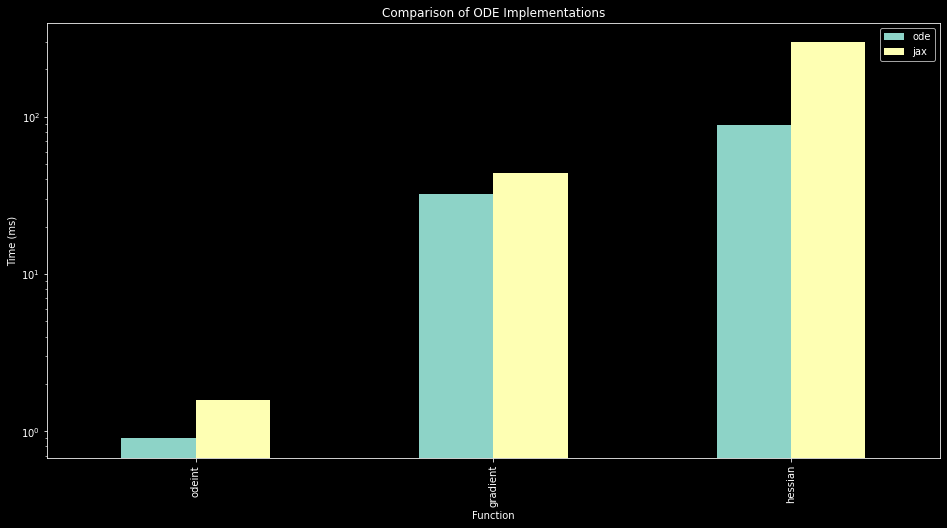

In [556]:
visual = results.plot.bar()  # Showing the plot 
visual.set_yscale("log")
visual.set_title("Comparison of ODE Implementations")
visual.set_ylabel("Time (ms)")
visual.set_xlabel("Function")